In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
import geopandas as gpd
from shapely.geometry import Point
import os

In [2]:
# Read in the cleaned arrest logs
logs_path = os.path.join(os.path.dirname(os.path.abspath('..')), 'datasets', 'springfield_arrest_logs.csv')
logs = pd.read_csv(logs_path)
# Also read in the pickled file which contains lats and longs of the arrests (for those with valid street addresses)
logs_with_geocoding_path = os.path.join(os.path.dirname(os.path.abspath('..')), 'datasets', 'springfield_logs_with_geocoding')
logs_with_geocoding = pd.read_pickle(logs_with_geocoding_path)

## Figure out which offenses were most common in arrests of individuals aged 18-20

In [3]:
# Grab the 881 arrests in which the suspect was between the ages of 18 and 20
logs_18_20 = logs[(logs['Suspect Age on Date of Arrest']>17) & (logs['Suspect Age on Date of Arrest']<21)]
logs_18_20.set_index(pd.Index(range(len(logs_18_20))),inplace=True)

In [4]:
# Find the maximum number of different charges which were mentioned in a single arrest
logs_18_20['Offense Codes'].str.count(';').max()

17

In [5]:
# In order to make some graphs, I first need to know how many different types of charges there are in the dataset
offense_codes_list = []
def get_offense_codes(record):
    codes = record['Offense Codes'].split(';')
    for offense_code in codes:
        if offense_code not in offense_codes_list:
            offense_codes_list.append(offense_code)
logs_18_20.apply(lambda x: get_offense_codes(x),axis=1)
# Remove some improperly formatted arrest codes
offense_codes_list.remove('')
offense_codes_list.remove('VANDALIZE')
offense_codes_list.remove('BURGLARIOUS')
offense_codes_list.remove('LARCENY')
offense_codes_list.remove('DESTRUCTION')
offense_codes_list.remove('(1)')

In [6]:
# Now, I'm going to make a bar graph showing which offenses appear most frequently
code_frequencies_df = pd.DataFrame(data=None,index=offense_codes_list,columns=['Number of Arrests Citing This Charge','Offense Name'])
for code in offense_codes_list:
    code_frequencies_df.loc[code] = len(logs_18_20[logs_18_20['Offense Codes'].str.contains(code)])
code_frequencies_df = code_frequencies_df.sort_values(by='Number of Arrests Citing This Charge').iloc[::-1]

In [7]:
# I need to get the names of the offenses corresponding to each code so the graph will be meaningful
for code in offense_codes_list:
    first_record_with_code = logs_18_20[logs_18_20['Offense Codes'].str.contains(code)].iloc[0]
    code_loc_in_suspect_list = first_record_with_code['Offense Codes'].split(';').index(code)
    code_frequencies_df['Offense Name'].loc[code] = first_record_with_code['Offense Descriptions'].split(';')[code_loc_in_suspect_list]
code_frequencies_df.loc['90Z']['Offense Name'] = 'ALL OTHER OFFENSES (incl. oustanding warrants)'

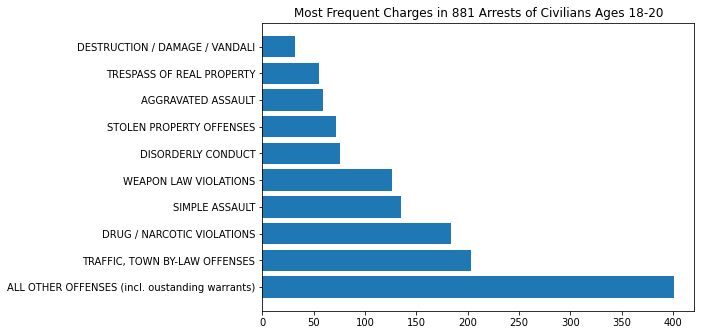

In [8]:
top_ten_codes = code_frequencies_df.head(10)
top_ten_codes_figure = plt.figure()
top_ten_codes_axes = top_ten_codes_figure.add_axes([0,0,1,1])
top_ten_codes_axes.barh(np.arange(len(top_ten_codes)),top_ten_codes['Number of Arrests Citing This Charge'],tick_label=top_ten_codes['Offense Name'])
top_ten_codes_axes.set_title('Most Frequent Charges in 881 Arrests of Civilians Ages 18-20')
top_ten_codes_figure.show()

In [9]:
# Check on the number of 'All Other Offenses' charges which describe an outstanding warrant, out of a collection of 401 arrests
len(logs_18_20[(logs_18_20['Offense Codes'].str.contains('90Z')) & (logs_18_20['Offenses'].str.lower().str.contains('warrant'))])

266

## Make a Folium map of all arrests of individuals aged 18-20 in Springfield

In [10]:
# Initialize a map of Springfield
the_map = folium.Map(location=[42.1015, -72.5898])
# Only keep the addresses which actually got mapped to legitimate locations
logs_18_20_for_map = logs_with_geocoding[(logs_with_geocoding['Suspect Age on Date of Arrest']>17) & (logs_with_geocoding['Suspect Age on Date of Arrest']<21)]
addresses = logs_18_20_for_map['Geocoded Addresses'].dropna()
lats = addresses.apply(lambda x: x.latitude)
longs = addresses.apply(lambda x: x.longitude)
latslongs = pd.concat([lats, longs],axis=1)
latslongs.columns = ['Latitude','Longitude']
# Drop one outlier that got assigned to the wrong lat/long
latslongs = latslongs[latslongs['Longitude']>-73]

In [11]:
# Check on what percentage of the arrests were mapped to valid addresses
print(len(latslongs) / len(logs_18_20_for_map))

0.8864926220204313


In [12]:
# Add each geocoded arrest location to the map and display the result
for i in range(len(addresses)):
    folium.CircleMarker(location=[addresses.iloc[i].latitude, addresses.iloc[i].longitude],radius=2).add_to(the_map)
sw = latslongs[['Latitude', 'Longitude']].min().values.tolist()
ne = latslongs[['Latitude', 'Longitude']].max().values.tolist()

the_map.fit_bounds(sw, ne) 
the_map

## Also make a similar map in GeoPandas, to showcase the discrete boundaries of Census block groups

In [13]:
# Import the shapefile for Massachusetts
shapefile_block_groups_path = os.path.join(os.path.dirname(os.path.abspath('')), 'datasets', 'tl_2019_25_bg','tl_2019_25_bg.shp')
block_groups_df_ma = gpd.read_file(shapefile_block_groups_path)

In [14]:
# Keep a list of all census tracts in Springfield
census_tracts_springfield = [8001.01, 8001.02, 8002.01, 8002.02, 8003, 8004, 8005, 8006, 8007, 8008, 8009, 8011.01, 8011.02, 8012, 8013, 8014.01, 8014.02, 8015.01, 8015.02, 8015.03, 8016.01, 8016.02, 8016.03, 8016.04, 8016.05, 8017, 8018, 8019.01, 8019.02, 8020, 8021, 8022, 8023, 8024, 8025, 8026.01, 8026.02]
census_tracts_springfield = [str(elem) for elem in census_tracts_springfield]

# Figure out which of Massachusetts's block groups are actually in Springfield
census_tracts_digits = census_tracts_springfield.copy()
# Modify our list of SPringfield census tracts to have every one be exactly six digits long
for i in range(len(census_tracts_digits)):
    if '.' in census_tracts_digits[i]:
        census_tracts_digits[i] = census_tracts_digits[i].replace('.','')
    elif len(census_tracts_digits[i]) == 4:
        census_tracts_digits[i] = census_tracts_digits[i] + "00"

bg_springfield_boolean = block_groups_df_ma.apply(lambda x: x['TRACTCE'] in census_tracts_digits,axis=1)
bg_springfield = block_groups_df_ma[bg_springfield_boolean]

# Add shapely.geometry.Point labels to each arrest for later mapping
logs_18_20_with_points = logs_18_20_for_map.dropna()
logs_18_20_with_points['shapely.geometry.Point'] = logs_18_20_with_points.apply(lambda x: Point(x['Geocoded Addresses'].longitude,x['Geocoded Addresses'].latitude), axis=1)

# Define a helper function to tell us in which block group a particular incident occurred
def find_springfield_block_group(point, block_groups):
    for i in range(len(block_groups.index)):
        if block_groups.iloc[i]['geometry'].contains(point):
            # We need a more detailed unique identifier for block groups: the GEOID, which combines state, county, census tract, and block number within that tract
            return block_groups.iloc[i]['GEOID']

# For each incident, find the block group where it occurred
logs_18_20_with_points['Block Group'] = logs_18_20_with_points.apply(lambda x: find_springfield_block_group(x['shapely.geometry.Point'], bg_springfield), axis=1)

# For each block group, sum up the number of incidents that occurred there
bg_springfield['Incident Count'] = bg_springfield.apply(lambda x: len(logs_18_20_with_points[logs_18_20_with_points['Block Group']==x.GEOID]),axis=1)

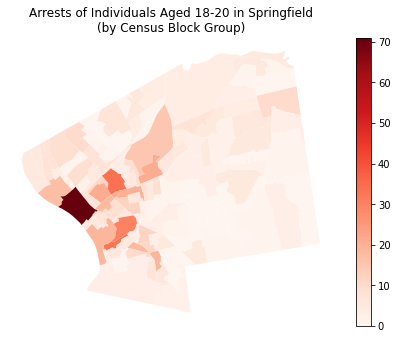

In [15]:
# Here, we'll plot the arrests at the Census Block Group level
# I'm just reusing the code I wrote for creating a map with GeoPandas when I was first working with the New Bedford dataset
incidents_by_bg = plt.figure()
ibbg_axes = incidents_by_bg.add_axes([0,0,1,1])

ibbg_plot = bg_springfield.plot(column='Incident Count',cmap='Reds',ax=ibbg_axes,legend=True)

ibbg_axes.axis('off')
ibbg_axes.set_title('Arrests of Individuals Aged 18-20 in Springfield\n(by Census Block Group)')
incidents_by_bg.show()

## Figure out which officers (in terms of their badge numbers) arrested the most young people

In [16]:
logs_18_20_for_map.groupby(by='Arrest. ID').count()['Arrest'].sort_values(ascending=False).head(10)

Arrest. ID
M467      48
100135    18
51390     17
B218      15
101951    14
G889      13
103493    13
B388      11
106895    10
111525    10
Name: Arrest, dtype: int64